# Proyek Klasifikasi Gambar: Large Scale Fish Dataset
- **Nama:** Faris Nur Rizqiawan
- **Email:** farisnur07@gmail.com
- **ID Dicoding:** MC179D5Y0233

## Import Semua Packages/Library yang Digunakan

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img
from sklearn.model_selection import train_test_split
import random
import zipfile
import shutil
import pathlib


## Data Preparation

### Data Loading

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Path ke dataset
data_dir = '/content/drive/MyDrive/Colab Notebooks/Klasifikasi_Gambar_DBS/Large_fish_dataset/Images'

# Cek isi folder kelas
classes = os.listdir(data_dir)
print(f"Jumlah kelas: {len(classes)}")
print("Contoh nama kelas:", classes[:9])

Jumlah kelas: 9
Contoh nama kelas: ['Black Sea Sprat', 'Hourse Mackerel', 'Red Sea Bream', 'Red Mullet', 'Gilt-Head Bream', 'Sea Bass', 'Shrimp', 'Striped Red Mullet', 'Trout']


### Data Preprocessing

#### Split Dataset

In [ ]:
# Tentukan ukuran split
train_size = 0.7  # 70% untuk training
val_size = 0.15   # 15% untuk validation
test_size = 0.15  # 15% untuk testing

# Daftar nama kelas
classes = os.listdir(data_dir)

# Membuat folder untuk split
split_dir = '/content/drive/MyDrive/Colab Notebooks/Klasifikasi_Gambar_DBS/Large_fish_dataset/split_data'
os.makedirs(split_dir, exist_ok=True)

# Loop untuk setiap kelas dan split gambar ke folder training, validation, dan testing
for class_name in classes:
    class_dir = os.path.join(data_dir, class_name)
    # Ambil semua gambar di dalam folder kelas
    images = os.listdir(class_dir)

    # Split dataset menjadi train dan temp
    train_images, temp_images = train_test_split(images, train_size=train_size, random_state=42)
    # Split temp menjadi validation dan test
    val_images, test_images = train_test_split(temp_images, test_size=test_size/(test_size + val_size), random_state=42)

    # Buat folder untuk masing-masing split
    train_class_dir = os.path.join(split_dir, 'train', class_name)
    val_class_dir = os.path.join(split_dir, 'val', class_name)
    test_class_dir = os.path.join(split_dir, 'test', class_name)

    for sub_dir in [train_class_dir, val_class_dir, test_class_dir]:
        os.makedirs(sub_dir, exist_ok=True)

    # Pindahkan gambar ke folder yang sesuai
    for img in train_images:
        shutil.copy(os.path.join(class_dir, img), os.path.join(train_class_dir, img))
    for img in val_images:
        shutil.copy(os.path.join(class_dir, img), os.path.join(val_class_dir, img))
    for img in test_images:
        shutil.copy(os.path.join(class_dir, img), os.path.join(test_class_dir, img))

print("Dataset telah dibagi menjadi train, val, dan test.")

Dataset telah dibagi menjadi train, val, dan test.


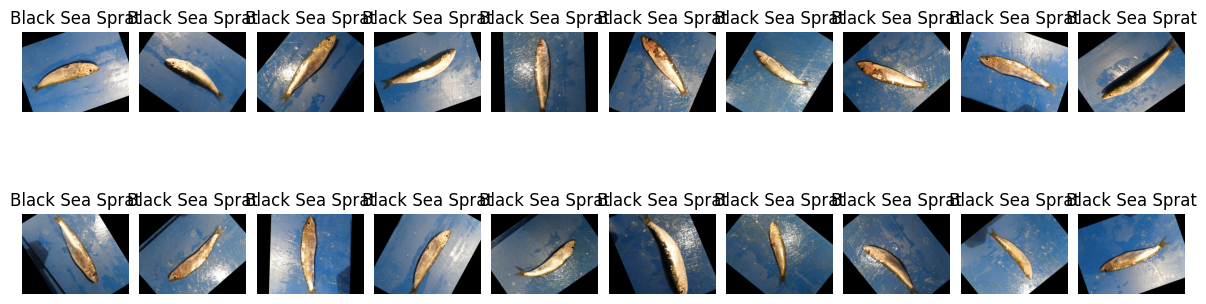

In [47]:
# Misalnya, menampilkan 20 gambar pertama dari dataset training
train_images_dir = os.path.join(split_dir, 'train')
fig, ax = plt.subplots(2, 10, figsize=(15, 4.5))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

# Ambil gambar dan label dari folder train untuk masing-masing kelas
train_images_list = []
class_names = []  # untuk menampung nama kelas
for class_name in os.listdir(train_images_dir):
    class_folder = os.path.join(train_images_dir, class_name)
    images = os.listdir(class_folder)
    for img in images:
        # Pastikan hanya file gambar yang diproses
        if img.endswith('.png') or img.endswith('.jpg') or img.endswith('.jpeg'):
            train_images_list.append(os.path.join(class_folder, img))
            class_names.append(class_name)

# Tampilkan 20 gambar pertama
for j in range(0, 2):
    for i in range(0, 10):
        img_path = train_images_list[i + j * 10]
        img = plt.imread(img_path)
        ax[j, i].imshow(img)
        ax[j, i].set_title(class_names[i + j * 10])
        ax[j, i].axis('off')

plt.show()

## Modelling

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Inisialisasi ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Path hasil split
split_dir = '/content/drive/MyDrive/Colab Notebooks/Klasifikasi_Gambar_DBS/Large_fish_dataset/split_data'

# Load train_gen
train_gen = train_datagen.flow_from_directory(
    os.path.join(split_dir, 'train'),
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

# Load val_gen
val_gen = val_datagen.flow_from_directory(
    os.path.join(split_dir, 'val'),
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

# Load test_gen (kalau nanti mau evaluasi)
test_gen = val_datagen.flow_from_directory(
    os.path.join(split_dir, 'test'),
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 5950 images belonging to 9 classes.
Found 1275 images belonging to 9 classes.
Found 1276 images belonging to 9 classes.


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Buat model CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),

    Dense(128, activation='relu'),
    Dropout(0.5),

    Dense(len(classes), activation='softmax')  # output sesuai jumlah kelas
])

# Compile model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Tampilkan ringkasan model
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,829,513 (18.42 MB)

 Trainable params: 4,829,513 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Buat callback
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/Colab Notebooks/Klasifikasi_Gambar_DBS/Large_fish_dataset/split_data/best_model.h5',   # path penyimpanan model terbaik
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

history = model.fit(
    train_gen,
    epochs=20,  # aku buat 30 supaya kalau EarlyStopping aktif bisa berhenti otomatis
    validation_data=val_gen,
    callbacks=[early_stop, checkpoint]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2463 - loss: 2.0209
Epoch 1: val_loss improved from inf to 1.04794, saving model to /content/drive/MyDrive/Colab Notebooks/Klasifikasi_Gambar_DBS/Large_fish_dataset/split_data/best_model.h5


186/186 ━━━━━━━━━━━━━━━━━━━━ 457s 2s/step - accuracy: 0.2469 - loss: 2.0194 - val_accuracy: 0.6494 - val_loss: 1.0479
Epoch 2/20
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5802 - loss: 1.1239
Epoch 2: val_loss improved from 1.04794 to 0.55735, saving model to /content/drive/MyDrive/Colab Notebooks/Klasifikasi_Gambar_DBS/Large_fish_dataset/split_data/best_model.h5


186/186 ━━━━━━━━━━━━━━━━━━━━ 501s 2s/step - accuracy: 0.5804 - loss: 1.1234 - val_accuracy: 0.8173 - val_loss: 0.5573
Epoch 3/20
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7078 - loss: 0.7893
Epoch 3: val_loss improved from 0.55735 to 0.33848, saving model to /content/drive/MyDrive/Colab Notebooks/Klasifikasi_Gambar_DBS/Large_fish_dataset/split_data/best_model.h5


186/186 ━━━━━━━━━━━━━━━━━━━━ 498s 2s/step - accuracy: 0.7080 - loss: 0.7890 - val_accuracy: 0.8878 - val_loss: 0.3385
Epoch 4/20
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7861 - loss: 0.5696
Epoch 4: val_loss did not improve from 0.33848
186/186 ━━━━━━━━━━━━━━━━━━━━ 445s 2s/step - accuracy: 0.7862 - loss: 0.5694 - val_accuracy: 0.8894 - val_loss: 0.3631
Epoch 5/20
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8432 - loss: 0.4459
Epoch 5: val_loss improved from 0.33848 to 0.23710, saving model to /content/drive/MyDrive/Colab Notebooks/Klasifikasi_Gambar_DBS/Large_fish_dataset/split_data/best_model.h5


186/186 ━━━━━━━━━━━━━━━━━━━━ 448s 2s/step - accuracy: 0.8432 - loss: 0.4458 - val_accuracy: 0.9122 - val_loss: 0.2371
Epoch 6/20
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8616 - loss: 0.3891
Epoch 6: val_loss improved from 0.23710 to 0.15749, saving model to /content/drive/MyDrive/Colab Notebooks/Klasifikasi_Gambar_DBS/Large_fish_dataset/split_data/best_model.h5


186/186 ━━━━━━━━━━━━━━━━━━━━ 448s 2s/step - accuracy: 0.8617 - loss: 0.3889 - val_accuracy: 0.9459 - val_loss: 0.1575
Epoch 7/20
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8818 - loss: 0.3238
Epoch 7: val_loss improved from 0.15749 to 0.10025, saving model to /content/drive/MyDrive/Colab Notebooks/Klasifikasi_Gambar_DBS/Large_fish_dataset/split_data/best_model.h5


186/186 ━━━━━━━━━━━━━━━━━━━━ 495s 2s/step - accuracy: 0.8819 - loss: 0.3236 - val_accuracy: 0.9624 - val_loss: 0.1003
Epoch 8/20
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9094 - loss: 0.2489
Epoch 8: val_loss improved from 0.10025 to 0.09577, saving model to /content/drive/MyDrive/Colab Notebooks/Klasifikasi_Gambar_DBS/Large_fish_dataset/split_data/best_model.h5


186/186 ━━━━━━━━━━━━━━━━━━━━ 434s 2s/step - accuracy: 0.9094 - loss: 0.2489 - val_accuracy: 0.9710 - val_loss: 0.0958
Epoch 9/20
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9235 - loss: 0.2112
Epoch 9: val_loss improved from 0.09577 to 0.07181, saving model to /content/drive/MyDrive/Colab Notebooks/Klasifikasi_Gambar_DBS/Large_fish_dataset/split_data/best_model.h5


186/186 ━━━━━━━━━━━━━━━━━━━━ 450s 2s/step - accuracy: 0.9235 - loss: 0.2113 - val_accuracy: 0.9765 - val_loss: 0.0718
Epoch 10/20
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9292 - loss: 0.1821
Epoch 10: val_loss did not improve from 0.07181
186/186 ━━━━━━━━━━━━━━━━━━━━ 500s 2s/step - accuracy: 0.9292 - loss: 0.1820 - val_accuracy: 0.9459 - val_loss: 0.1699
Epoch 11/20
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9367 - loss: 0.1775
Epoch 11: val_loss did not improve from 0.07181
186/186 ━━━━━━━━━━━━━━━━━━━━ 441s 2s/step - accuracy: 0.9367 - loss: 0.1775 - val_accuracy: 0.9561 - val_loss: 0.1230
Epoch 12/20
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9407 - loss: 0.1673
Epoch 12: val_loss did not improve from 0.07181
186/186 ━━━━━━━━━━━━━━━━━━━━ 438s 2s/step - accuracy: 0.9407 - loss: 0.1673 - val_accuracy: 0.9702 - val_loss: 0.0732
Epoch 13/20
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9393 - loss: 0.1710
Epoch 13: val_loss improved from 0.07181

186/186 ━━━━━━━━━━━━━━━━━━━━ 445s 2s/step - accuracy: 0.9393 - loss: 0.1709 - val_accuracy: 0.9898 - val_loss: 0.0284
Epoch 14/20
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9589 - loss: 0.1228
Epoch 14: val_loss did not improve from 0.02844
186/186 ━━━━━━━━━━━━━━━━━━━━ 439s 2s/step - accuracy: 0.9589 - loss: 0.1229 - val_accuracy: 0.9741 - val_loss: 0.0648
Epoch 15/20
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9459 - loss: 0.1521
Epoch 15: val_loss improved from 0.02844 to 0.01655, saving model to /content/drive/MyDrive/Colab Notebooks/Klasifikasi_Gambar_DBS/Large_fish_dataset/split_data/best_model.h5


186/186 ━━━━━━━━━━━━━━━━━━━━ 437s 2s/step - accuracy: 0.9459 - loss: 0.1521 - val_accuracy: 0.9945 - val_loss: 0.0166
Epoch 16/20
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9596 - loss: 0.1167
Epoch 16: val_loss did not improve from 0.01655
186/186 ━━━━━━━━━━━━━━━━━━━━ 429s 2s/step - accuracy: 0.9596 - loss: 0.1167 - val_accuracy: 0.9106 - val_loss: 0.3174
Epoch 17/20
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9513 - loss: 0.1431
Epoch 17: val_loss improved from 0.01655 to 0.01042, saving model to /content/drive/MyDrive/Colab Notebooks/Klasifikasi_Gambar_DBS/Large_fish_dataset/split_data/best_model.h5


186/186 ━━━━━━━━━━━━━━━━━━━━ 436s 2s/step - accuracy: 0.9513 - loss: 0.1430 - val_accuracy: 0.9984 - val_loss: 0.0104
Epoch 18/20
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9573 - loss: 0.1261
Epoch 18: val_loss did not improve from 0.01042
186/186 ━━━━━━━━━━━━━━━━━━━━ 448s 2s/step - accuracy: 0.9573 - loss: 0.1259 - val_accuracy: 0.9961 - val_loss: 0.0154
Epoch 19/20
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9605 - loss: 0.1114
Epoch 19: val_loss did not improve from 0.01042
186/186 ━━━━━━━━━━━━━━━━━━━━ 431s 2s/step - accuracy: 0.9605 - loss: 0.1115 - val_accuracy: 0.9435 - val_loss: 0.1509
Epoch 20/20
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9624 - loss: 0.1094
Epoch 20: val_loss did not improve from 0.01042
186/186 ━━━━━━━━━━━━━━━━━━━━ 441s 2s/step - accuracy: 0.9624 - loss: 0.1094 - val_accuracy: 0.9875 - val_loss: 0.0326


## Evaluasi dan Visualisasi

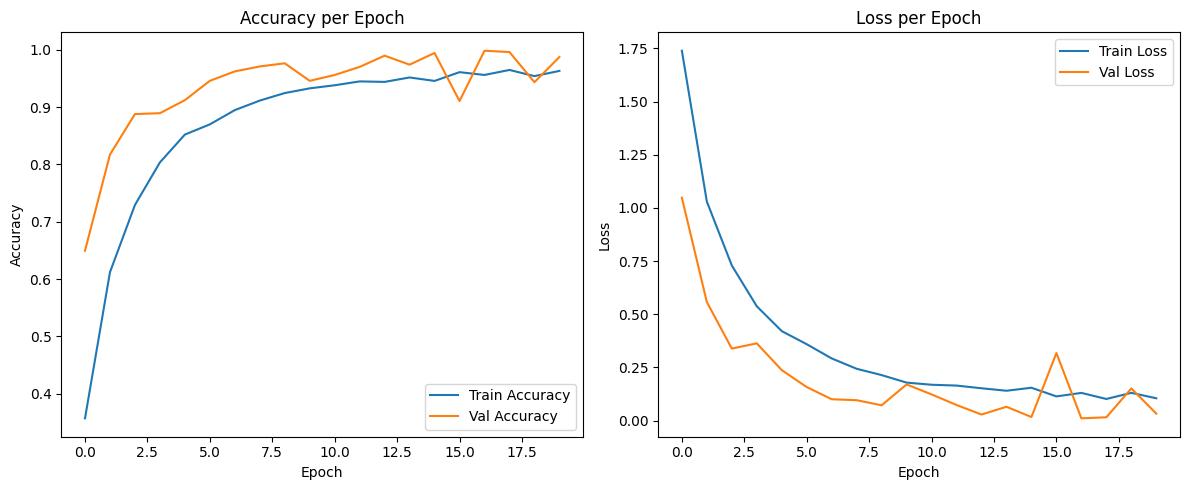

In [12]:
import matplotlib.pyplot as plt

# Plot akurasi
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [13]:
# Load model terbaik kalau mau
best_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Klasifikasi_Gambar_DBS/Large_fish_dataset/split_data/best_model.h5')

# Evaluasi di test set
test_loss, test_acc = best_model.evaluate(test_gen)
print(f"Test Accuracy: {test_acc:.4f}")


40/40 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.9993 - loss: 0.0104
Test Accuracy: 0.9976


## Konversi Model

In [62]:
model.save('/content/drive/MyDrive/Colab Notebooks/Klasifikasi_Gambar_DBS/Large_fish_dataset/split_data/saved_model.keras')


In [64]:
import tensorflow as tf

# Tentukan path folder tempat model akan disimpan
saved_model_path = '/content/drive/MyDrive/Colab Notebooks/Klasifikasi_Gambar_DBS/Large_fish_dataset/saved_model'

# Simpan model sebagai SavedModel
tf.saved_model.save(model, saved_model_path)


In [36]:
# Convert ke TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save .tflite
with open('/content/drive/MyDrive/Colab Notebooks/Klasifikasi_Gambar_DBS/Large_fish_dataset/split_data/model.tflite', 'wb') as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmpb8da8w2m'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 9), dtype=tf.float32, name=None)
Captures:
  139527214277904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139527214283088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139527214283664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139527214284240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139527214283472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139527214284432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139527214284048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139527214272720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139527212106768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139527212108112: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [53]:
import os

# Dapatkan daftar kelas dari direktori dataset
class_names = os.listdir('/content/drive/MyDrive/Colab Notebooks/Klasifikasi_Gambar_DBS/Large_fish_dataset/split_data/train')

# Simpan nama kelas ke dalam label.txt
with open('/content/drive/MyDrive/Colab Notebooks/Klasifikasi_Gambar_DBS/Large_fish_dataset/split_data/label.txt', 'w') as f:
    for class_name in class_names:
        f.write(f"{class_name}\n")


In [28]:
!pip install tensorflowjs


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.5 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [37]:
# Load model dari file .keras
model = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Klasifikasi_Gambar_DBS/Large_fish_dataset/split_data/saved_model.keras')

# Convert dan simpan ke folder tfjs_model
tfjs_target_dir = '/content/drive/MyDrive/Colab Notebooks/Klasifikasi_Gambar_DBS/Large_fish_dataset/split_data/tfjs_model'
tfjs.converters.save_keras_model(model, tfjs_target_dir)

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


failed to lookup keras version from the file,
    this is likely a weight only file


## Inference (Optional)

In [42]:
from tensorflow import keras
from tensorflow.keras.preprocessing import image
import numpy as np

# Load model
model = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Klasifikasi_Gambar_DBS/Large_fish_dataset/split_data/saved_model.keras')

# Path gambar yang mau diprediksi (satu gambar)
img_path = '/content/drive/MyDrive/Colab Notebooks/Klasifikasi_Gambar_DBS/Large_fish_dataset/split_data/test/Black Sea Sprat/00800.png'

# Load dan preprocess gambar
img = image.load_img(img_path, target_size=(150, 150))  # Sesuaikan dengan input modelmu
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # tambah batch dimension
img_array /= 255.0  # normalisasi

# Prediksi
prediction = model.predict(img_array)
predicted_class = np.argmax(prediction, axis=1)

print(f"Predicted class: {predicted_class}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
Predicted class: [0]


In [43]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image

# Load TFLite model
interpreter = tf.lite.Interpreter(model_path='/content/drive/MyDrive/Colab Notebooks/Klasifikasi_Gambar_DBS/Large_fish_dataset/split_data/model.tflite')
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Load dan preprocess gambar baru
img_path = '/content/drive/MyDrive/Colab Notebooks/Klasifikasi_Gambar_DBS/Large_fish_dataset/split_data/test/Black Sea Sprat/00800.png'  # <- ganti path gambar
img = image.load_img(img_path, target_size=(150, 150))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0

# Set input tensor
interpreter.set_tensor(input_details[0]['index'], img_array.astype(np.float32))

# Inference
interpreter.invoke()

# Get prediction
output_data = interpreter.get_tensor(output_details[0]['index'])
predicted_class = np.argmax(output_data, axis=1)

print("Predicted class (TFLite):", predicted_class)


Predicted class (TFLite): [0]


In [49]:
# Path hasil split (sama seperti sebelumnya)
split_dir = '/content/drive/MyDrive/Colab Notebooks/Klasifikasi_Gambar_DBS/Large_fish_dataset/split_data'

# Load test_gen (kalau nanti mau evaluasi) - Anda sudah punya ini
test_gen = val_datagen.flow_from_directory(
    os.path.join(split_dir, 'test'),
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Load model (pastikan Anda sudah load model)
# model = keras.models.load_model('/path/to/your/model.keras')

# Prediksi
predictions = model.predict(test_gen, steps=len(test_gen))  # Inferensi pada seluruh batch test_gen

Found 1276 images belonging to 9 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


40/40 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step
